In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# unmount google drive directory code 
# drive.flush_and_unmount()

In [0]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import numpy as np
import matplotlib as mpl

In [0]:
# you can either download the file from here or directly open it after mounting google drive

#!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Electronics_5.json.gz
#!wget https://drive.google.com/file/d/18wfGKYb0dgc6sUQn9Szylc6Qn5gPHdkN

In [3]:
# set working directory -> you must set the path into which you have uploaded the zipped file
# this is required in the case of colab or local 
%cd /content/drive/My\ Drive/SNLP\ Project
# %cd Source/repos/Sentiment-Analysis-using-Deep-Learning

/content/drive/My Drive/SNLP Project


In [4]:
# list content of drive
%ls

 Electronics_5.json.gz  'Project Ideas.gdoc'     'Report MetaData'/
 electronics_5.npy      'Project Proposal.gdoc'


In [0]:
# First way to read data : 
# Code to read json.gz into array

data = []
with gzip.open('Electronics_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

        if len(data) % 100000 == 0 :
          print(len(data))
    
# total length of list, this number equals total number of products
print('Final length', len(data))

# first row of the list
print(data[0])


In [0]:
# Save data into numpy binary files so we dont have to load it from a json file each time
np.save('electronics_5.npy', data)
print('saved')

In [0]:
data = np.load('electronics_5.npy', allow_pickle=True)

# total length of list, this number equals total number of products
print(len(data))


In [0]:
# alternatively Code to read json file into Panda Array 
with gzip.open('Electronics_5.json.gz') as json_file:      
    df = json_file.readlines()
    # this line below may take at least 8-10 minutes of processing for 4-5 million rows. It converts all strings in list to actual json objects. 
    df = list(map(json.loads, df)) 

df = pd.DataFrame(df)


#for i, row in data.iterrows():
#    ifor_val = something
#    if <condition>:
#      ifor_val = something_else
#    df.at[i,'ifor'] = ifor_val

In [20]:
total_cols = ['overall','vote','verified','reviewTime','reviewerID','asin','style','reviewerName','reviewText','summary','unixReviewTime','image']

# cols we want to explore
review_cols = ['overall','vote','verified','reviewerID','asin','reviewerName']

# data exploration 
# df.info()

# check if columns contain null values 
pd.isnull(df).any()

for col in review_cols:
  print(col)

  print('\n Total Uniques')
  print(df[col].nunique())
  print('\n Uniques Items')
  print(df[col].unique())
  print('\n Uniques Counts')
  print(df[col].value_counts())

  print('---------------------------------')

overall

 Total Uniques
5

 Uniques Items
[5. 3. 4. 2. 1.]

 Uniques Counts
5.0    4323582
4.0    1137393
3.0     504781
1.0     467158
2.0     306676
Name: overall, dtype: int64
---------------------------------
vote

 Total Uniques
1171

 Uniques Items
['67' '5' '4' ... '1,542' '1,121' '705']

 Uniques Counts
2        310316
3        161839
4         96513
5         65587
6         46409
          ...  
716           1
930           1
1,176         1
816           1
1,385         1
Name: vote, Length: 1171, dtype: int64
---------------------------------
verified

 Total Uniques
2

 Uniques Items
[ True False]

 Uniques Counts
True     6038416
False     701174
Name: verified, dtype: int64
---------------------------------
reviewerID

 Total Uniques
728719

 Uniques Items
['AAP7PPBU72QFM' 'A2E168DTVGE6SV' 'A1ER5AYS3FQ9O3' ... 'ALQRGMBK4U4CZ'
 'A97SFUJ82RSGA' 'A7NS5NFV55Q8F']

 Uniques Counts
A680RUE1FDO8B     604
A3OXHLG6DIBRW8    519
ADLVFFE4VBT8      499
A1X1CEGHTHMBL1    444
A31N0XY

In [0]:
# Get an idea of review text and summary length incase we want to encode them as params 
df['reviewText_len'] = df['reviewText'].map(lambda x: len(str(x)))
df['summary_len'] = df['summary'].map(lambda x: len(str(x)))

In [7]:
df['reviewText_len'].describe().apply("{0:.3f}".format)

count    6739590.000
mean         354.149
std          648.971
min            1.000
25%           55.000
50%          155.000
75%          384.000
max        33331.000
Name: reviewText_len, dtype: object

In [8]:
df['summary_len'].describe().apply("{0:.3f}".format)

count    6739590.000
mean          25.619
std           19.886
min            1.000
25%           10.000
50%           19.000
75%           35.000
max          353.000
Name: summary_len, dtype: object

ERROR! Session/line number was not unique in database. History logging moved to new session 60


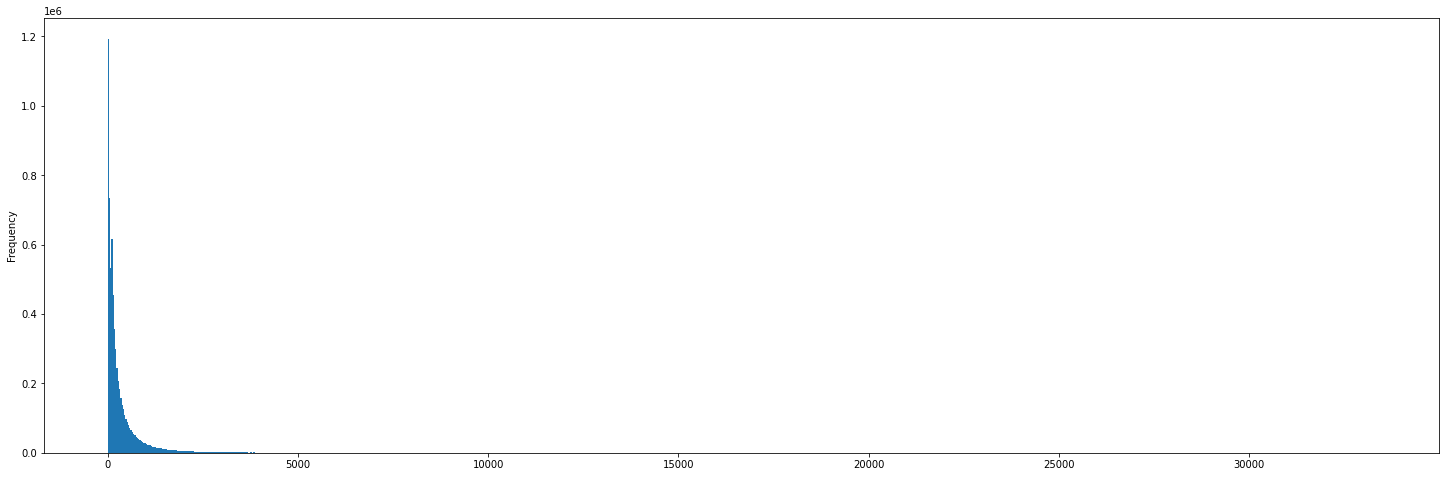

In [56]:
# plot the lengths to get a graphical view of the data 
df['reviewText_len'].plot(kind='hist', bins=1000, figsize=(25,8))

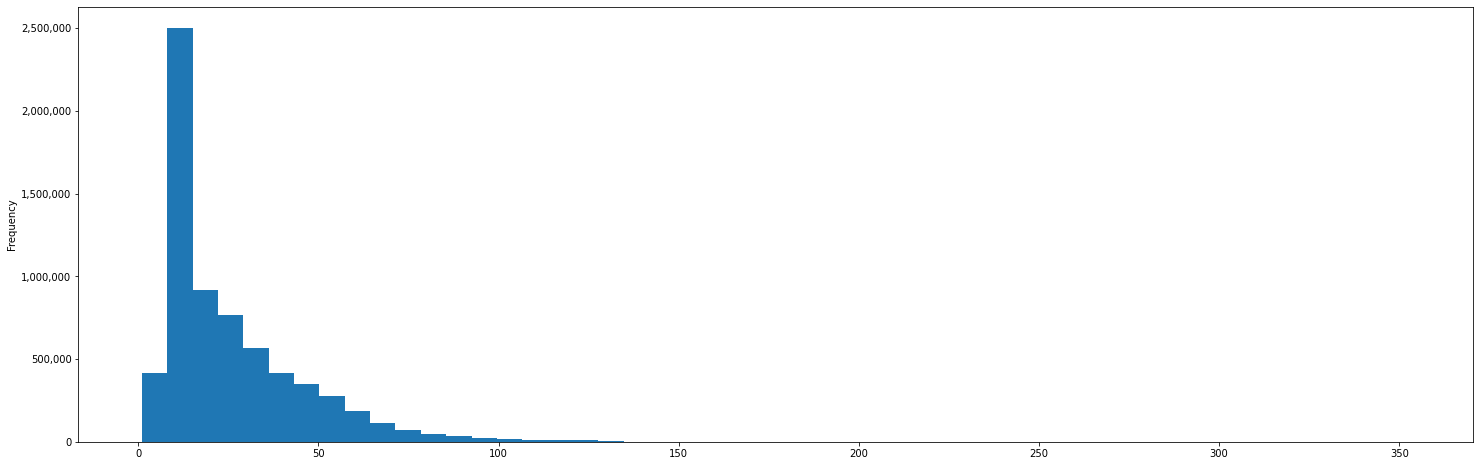

In [61]:

# plot the lengths to get a graphical view of the data 
ax = df['summary_len'].plot(kind='hist', bins=50, figsize=(25,8))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


In [0]:
import string
import re

# from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
snb_stemmer = SnowballStemmer("english")
# from nltk.stem import WordNetLemmatizer
# wordnet_lemmatizer = WordNetLemmatizer()


#https://github.com/abdulfatir/twitter-sentiment-analysis/blob/master/code/preprocess.py

def preprocess_sent(review,task):
  global preproc_counter
  if(preproc_counter % 10000 == 0):
    print('----Preprocessing '+task+ ' ---- ', preproc_counter)

  preproc_counter+= 1

  processed_review = []
  # Convert to lower case
  review = str(review).lower()
  # Replaces URLs with the word URL
  review = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', review)
  # Replaces #hashtag with hashtag
  review = re.sub(r'#(\S+)', r' \1 ', review)
  # Replace 2+ dots with space
  review = re.sub(r'\.{2,}', ' ', review)
  # Strip space, " and ' from tweet
  # review = review.strip(' "\'')
  # Replace emojis with either EMO_POS or EMO_NEG
  review = handle_emojis(review)

  # Replace multiple spaces with a single space
  review = re.sub(r'\s+', ' ', review)
  words = review.split()

  for word in words:
    word = preprocess_word(word)
    word = str(snb_stemmer.stem(word))
    processed_review.append(word)

  return ' '.join(processed_review)


def preprocess_word(review):
  # Remove punctuation
  word = review.strip('\'"?!,.():;')
  # Convert more than 2 letter repetitions to 2 letter
  # funnnnny / hmmmmm --> funny / hmm
  word = re.sub(r'(.)\1+', r'\1\1', word)
  # Remove - and '
  word = re.sub(r'(-|\')', '', word)

  return word


def handle_emojis(text):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', text)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    text = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', text)
    # Love -- <3, :*
    text = re.sub(r'(<3|:\*)', ' EMO_POS ', text)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    text = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', text)
    # Sad -- :-(, : (, :(, ):, )-:
    text = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', text)
    # Cry -- :,(, :'(, :"(
    text = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', text)
    return text

In [15]:
# DATA PREPROCESSING PART

# testing 
preproc_counter = 0 

# Clean the dataframe reviewText and Summary columns
df['reviewText'] = df['reviewText'].map(lambda x: preprocess_sent(x,'reviewText'))
print('---- processed reviewText ----')

# testing 
preproc_counter = 0

df['summary'] = df['summary'].map(lambda x: preprocess_sent(x,'summary'))
print('---- processed summary ----')

----Preprocessing reviewText ----  0
----Preprocessing reviewText ----  10000
----Preprocessing reviewText ----  20000
----Preprocessing reviewText ----  30000
----Preprocessing reviewText ----  40000
----Preprocessing reviewText ----  50000
----Preprocessing reviewText ----  60000
----Preprocessing reviewText ----  70000
----Preprocessing reviewText ----  80000
----Preprocessing reviewText ----  90000
----Preprocessing reviewText ----  100000
----Preprocessing reviewText ----  110000
----Preprocessing reviewText ----  120000
----Preprocessing reviewText ----  130000
----Preprocessing reviewText ----  140000
----Preprocessing reviewText ----  150000
----Preprocessing reviewText ----  160000
----Preprocessing reviewText ----  170000
----Preprocessing reviewText ----  180000
----Preprocessing reviewText ----  190000
----Preprocessing reviewText ----  200000
----Preprocessing reviewText ----  210000
----Preprocessing reviewText ----  220000
----Preprocessing reviewText ----  230000
----Pr

In [0]:
# now that we have cleant the 2 main columns lets save them 
# consider this a checkpoint incase colab crashes 

from datetime import datetime

# datetime object containing current date and time
now = datetime.now()

# Apr-02-2020_22-31-25
dt_string = now.strftime("%b-%d-%Y_%H-%M")

print(dt_string)

df.to_hdf('data.h5', key='df', mode='w')

#df.to_parquet('df_'+dt_string+'.parquet.gzip',compression='gzip')
#pd.read_parquet('df.parquet.gzip')


Apr-02-2020_22-41


In [0]:



from nltk import pos_tag, word_tokenize
import tensorflow as tf
from sklearn.utils import shuffle

# need to remove punctuation, see compatibility with penn treebank

In [16]:
df

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,reviewText_len,summary_len
0,5.0,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,{'Format:': ' Hardcover'},D. C. Carrad,this is the best novel i have read in 2 or 3 y...,a star is born,937612800,NaN,1095,14
1,3.0,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,{'Format:': ' Kindle Edition'},Evy,page and page of introspect in the style of wr...,a stream of conscious novel,1382486400,NaN,456,31
2,5.0,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,{'Format:': ' Paperback'},Kcorn,this is the kind of novel to read when you hav...,im a huge fan of the author and this one did n...,1220313600,NaN,2102,60
3,5.0,13,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,{'Format:': ' Hardcover'},Caf Girl Writes,what gorgeous languag what an incred writer th...,the most beauti book i have ever read,968025600,NaN,1209,41
4,3.0,8,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,{'Format:': ' Hardcover'},W. Shane Schmidt,i was taken in by review that compar this book...,a dissent viewin part,949622400,NaN,1433,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6739585,4.0,NaN,True,"03 21, 2017",A33MAQA919J2V8,B01HJH40WU,NaN,Kurt Wurm,these seem like qualiti usb cabl time will tell,four star,1490054400,NaN,50,10
6739586,4.0,NaN,True,"01 9, 2017",A1AKHSCPD1BHM4,B01HJH40WU,NaN,C.L Momof3,work great love the longer cord as with ani co...,nice long cord,1483920000,NaN,152,14
6739587,5.0,2,True,"12 1, 2016",A2HUZO7MQAY5I2,B01HJH40WU,NaN,michael clontz,ok here is an odd thing that happen to me i cl...,not the correct product as link in the sale,1480550400,NaN,528,46
6739588,5.0,2,True,"11 29, 2016",AJJ7VX2L91X2W,B01HJH40WU,NaN,Faith,work well,five star,1480377600,NaN,11,10
